### Harmonize litter codes

The data being used is from two seperate projects. The data from Rhine outflow was collected and identified using the OSPAR coding system. The data from the Rhine source was collected and identified using the MLW system.

While the data collection process is the same, the coding system is not. There are more codes in the MLW coding method than in the OSPAR method. Both systems are identifying the same objects, the MLW system allows for more precise identification. For example in the MLW system plastic lids are seperated into three types

1. lids from drinks and foode type itmes
2. lids from non food items
3. lid from unknown source

The OSPAR method only gives one possible choice: 'plastic lids'. The MLW/MSFD coding system works well for defining local results and identifying specific object types, precious infformation for municpalities and organizations that are seeking to reudce thes objects in the environment.

The relationship of MLW codes to OSPAR codes is 'many to one', this means that one OSPAR code may translate to many different MLW codes. Given this realtionship it is impossible to convert from OSPAR to MLW accurately, however we can convert MLW to OSPAR without losing any of the details.

#### Tasks

1. Identify codes in the definitions files that do not match an OSPAR or MLW code
2. Identify codes that were generated for local purposes and reporting
3. Identify the codes in the Swiss data that do not have an appropriate OSPAR code
4. Map OSPAR code values to MLW values using the data provided by David Fleet
5. For any MLW codes not in the fleet data use the MLW master list to identify the correct OSPAR id
6. Map results from point five to the Swiss codes
7. Aggregate and test survey results before and after applyin ospar id
8. Make preliminary top ten

https://indicit-europa.eu/cms/wp-content/uploads/2017/05/guidance_monitoring_marine_litter_2013.pdf

https://www.ospar.org/documents?v=7260

In [1]:
# sys things
import os
import sys
import json

# networks
import requests

# data
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import resources.utilities.utility_functions as ut

### Setup and housekeeping

Retireve the data, set the start and end dates, make a directory to store outpur for the project and standardize the column names from the two sets of data.

In [2]:
# get folder extesions
data, beaches, codes, geo, output=ut.make_local_paths()
project_directory = ut.make_project_folder(output, "harmonized_results")


# code data
dutch_codes = pd.read_csv(codes+'/dutch_codes.csv')
swiss_codes = pd.read_csv(codes+'/swiss_codes.csv')

start_date = "2017-07-04"
end_date = "2019-04-24"

# this list was recieved from david fleet: one of the authors of the monitoring guide
joint_list = pd.read_csv(F"{codes}/jointcodes/ospar_mlw_fleet.csv")

# housekeeping
dutch_codes.fillna(0, inplace=True)
dutch_codes.rename(columns={'OSPAR_ID':'ospar_id', 'Description':'description'}, inplace=True)
swiss_codes.rename(columns={'ospar_code':'ospar_id'}, inplace=True)
swiss_codes.drop('Unnamed: 0', axis=1,inplace=True)

# survey_data
dutch_surveys = pd.read_csv(data+'/dataset_macrolitter_NL.csv')

# use the aggregated hd data. This accounts for the custom codes used in Switzerland
swiss_surveys = pd.read_csv(data+'/aggregated_hd_surveys.csv')

# location data
swiss_beaches = pd.read_csv(beaches+'/hammerdirt_beaches.csv')

print("\nlook for resources here\n")
print(data, beaches, codes, geo, output)


look for resources here

resources/surveydata resources/locationdata resources/mlwcodedefs resources/geodata output


#### columns standardized

In [3]:
print(F"\n\nColumns from cleaned up dutch data\n\n{dutch_codes.columns}\n")
print()

print(F"\nColumns from cleaned up swiss data\n\n{swiss_codes.columns}")




Columns from cleaned up dutch data

Index(['ID', 'description', 'category', 'ospar_id'], dtype='object')



Columns from cleaned up swiss data

Index(['code', 'material', 'description', 'source', 'source_two',
       'source_three', 'parent_code', 'direct', 'single_use', 'micro',
       'ospar_id'],
      dtype='object')


## Dutch codes

The dutch codes use the OSPAR coding system with a few codes added for local purposes. The local codes have a decimal place, OSPAR codes generally do not have decimal places, for example in the dutch data plastic bottles are differentiated by size and label.

__OSPAR id for bottles is 4__

_In the dutch data there are three codes 4.1, 4.2 and 4.3 each responding to the criteria established by the researcher._

#### Tasks

1. Create an identifier for child codes, make a column for that
2. Standardize the ospar_id column (get rid of child codes)
3. group the codes according to parent/child

In [4]:
# the first ten ducth codes
dutch_codes.iloc[:10]

,ID,description,category,ospar_id
0,plastic_6_packringen,Six pack ring,PO soft,1.0
1,plastic_tassen,Bag,PO soft,2.0
2,plastic_kleine_plastic_tasjes,Small bag,PO soft,3.0
3,plastic_drankflessen_groterdan_halveliter,Bottle (>= 0.5 L),PET,4.1
4,plastic_drankflessen_kleinerdan_halveliter,Bottle (< 0.5 L),PET,4.2
5,plastic_wikkels_van_drankflessen,Bottle label,PO soft,4.3
6,plastic_verpakking_van_schoonmaakmiddelen,Cleaning product packaging,PO hard,5.0
7,plastic_voedselverpakkingen_frietbakjes_etc,Food packaging,Polystyrene,6.0
8,plastic_cosmeticaverpakkingen,Cosmetics packaging,PO hard,7.0
9,plastic_motorolieverpakking_groterdan50cm,Motor oil packaging (>= 50 cm),PO hard,9.0


In [5]:
# process the dutch codes:


# convert all ospar_id values to int and store in a column called parent code
dutch_codes['parent_code'] = dutch_codes.ospar_id.round(0)
dutch_codes['parent_code'] = dutch_codes['parent_code'].astype('int')

# the local codes are decimal representations of the original ospar id
# take advantage of that to create a column that is the result of the difference
# between the 'parent_code' and the 'opsar_id' in the data set
dutch_codes['child_code'] = dutch_codes.ospar_id - dutch_codes.parent_code


# collect the child codes
child_codes = dutch_codes.loc[dutch_codes.child_code > 0]
ccodes = child_codes.parent_code.unique()

# all the codes with no remainder or where child_code = 0
parent_codes = dutch_codes.loc[dutch_codes.child_code == 0]

# this is the parent codes with no child code
pcodes = parent_codes.parent_code.unique()

# all the dutch codes that are not child codes:
# this all the parent codes
dcodesall = dutch_codes.parent_code.unique()

print("""
This is the OSPAR code list from the dutch data.\n
OSPAR codes that could not be typed to 'int' were counted as 0.\n
Any code with an ospar value of 0 was excluded\n
""")
print(dcodesall)
print(F"\nThese are the detail codes (child codes) used to better define the object:\n\n{ccodes}\n\n")


This is the OSPAR code list from the dutch data.

OSPAR codes that could not be typed to 'int' were counted as 0.

Any code with an ospar value of 0 was excluded


[   1    2    3    4    5    6    7    9   10   13   14   15   16   20
   21   24   25  113   31   32   33   36   38   40   42   43   44  117
   46   48 1172  462   47   22   19  472  212  481   11   39    8   17
   35   49   52   53   54   55   57   59   60   61   63   64   65   66
   67   62   68   69   72   73   74   75   81   78   79   83   77   84
   88   76   86   80   82  120   89   90   91   92   93   98  982  102
   97   99   18  100  101  103  104  105]

These are the detail codes (child codes) used to better define the object:

[  4 117  46   6  47  22  19   2  43  38  39  62  67  81 102   1]




In [6]:
# the dutch data with the new columns
dutch_codes.iloc[:10]

,ID,description,category,ospar_id,parent_code,child_code
0,plastic_6_packringen,Six pack ring,PO soft,1.0,1,0.0
1,plastic_tassen,Bag,PO soft,2.0,2,0.0
2,plastic_kleine_plastic_tasjes,Small bag,PO soft,3.0,3,0.0
3,plastic_drankflessen_groterdan_halveliter,Bottle (>= 0.5 L),PET,4.1,4,0.1
4,plastic_drankflessen_kleinerdan_halveliter,Bottle (< 0.5 L),PET,4.2,4,0.2
5,plastic_wikkels_van_drankflessen,Bottle label,PO soft,4.3,4,0.3
6,plastic_verpakking_van_schoonmaakmiddelen,Cleaning product packaging,PO hard,5.0,5,0.0
7,plastic_voedselverpakkingen_frietbakjes_etc,Food packaging,Polystyrene,6.0,6,0.0
8,plastic_cosmeticaverpakkingen,Cosmetics packaging,PO hard,7.0,7,0.0
9,plastic_motorolieverpakking_groterdan50cm,Motor oil packaging (>= 50 cm),PO hard,9.0,9,0.0


### Compare the dutch codes to the data provided by David Fleet

Identify any Dutch codes that do not match the OSPAR definitions. The fleet data is the standard, any OSPAR codes in the Dutch data that are not in the fleet data need to be indentified.

In [7]:
# process the joint_list:
# housekeeping
joint_list.rename(columns={'OSPAR-ID':'ospar_id','G-Code':'mlw_code'}, inplace=True)
joint_list['mlw_code'] = joint_list.mlw_code.astype('str')
joint_list.fillna(0, inplace=True)

# make a column of pairs (MLW, OSPAR)
joint_list['paired'] = list(zip(joint_list.mlw_code,joint_list.ospar_id))

# map values in both directions
jlistkeys = joint_list[['mlw_code','ospar_id']].copy()

# set up a mapper:
mlwkeyed = {x[0]:x[1] for x in list(joint_list.paired.unique())}
# osparkeyed = {x[1]:x[0] for x in list(joint_list.paired.unique())}

In [8]:
dutch_codes_not_in_ospar = [x for x in dutch_codes.parent_code.unique() if x not in joint_list.ospar_id.unique()]

print(F"These are the ducth codes that are not in the OSPAR definitions:\n{dutch_codes_not_in_ospar }")

These are the ducth codes that are not in the OSPAR definitions:
[1172, 462, 472, 212, 481, 982]


### The codes in the Dutch data that do not match the data from fleet:

In [9]:
print(F"\n\n{dutch_codes[dutch_codes.ospar_id.isin(dutch_codes_not_in_ospar)][['ospar_id','description']]}\n\n")



    ospar_id             description
34    1172.0  Foam fragment (< 5 cm)
35     462.0  Foam fragment (>=5 cm)
41     472.0          Foam (> 50 cm)
42     212.0                Foam cup
44     481.0            Water filter
99     982.0      Carton cotton swab




## Swiss codes

The Swiss codes use the MLW coding system with a some additional local codes. The survey results have been have been aggregate to MLW standard codes. However there is not a matching OSPAR id for all the MLW codes present in the aggregated swiss survey results.

#### Tasks

1. Identify and mark all non valid OSPAR codes
2. Identify parent and child codes
3. Identify the codes present in the survey data
4. Compare the number of unique MLW codes from step 3 to the number of unique MLW codes in the fleet data
5. Identify the MLW codes from the swiss data that are not in the fleet data
6. Identify the OSPAR codes from the swiss data that are not in the fleet data
7. Combine the MLW-OSPAR definitions from the two data sets. Give priority to definitions from the fleet data

In [10]:
# process the swiss codes


# housekeeping
def remove_nonintegers(x):
    if x in ['none','Ospar...']:
        new_def = 0
    else:
        new_def = x
    
    return new_def


swiss_codes['ospar_id'] = swiss_codes.ospar_id.map(lambda x: remove_nonintegers(x))
swiss_codes.fillna(0, inplace=True)
swiss_codes['ospar_id'] = swiss_codes.ospar_id.astype('int')

# get child and parent codes:
swiss_codes_parent = swiss_codes.loc[swiss_codes.parent_code == 'Parent code'].copy()
swiss_codes_child = swiss_codes.loc[swiss_codes.parent_code != 'Parent code'].copy()

# identify the codes that have actually been used:
swiss_pcodes_used = swiss_surveys[swiss_surveys.quantity > 0].code.unique()

# make a list of the codes in use:
scodes_used = swiss_codes_parent.loc[swiss_codes_parent.code.isin(swiss_pcodes_used)].copy()
scodes_used.set_index('code', inplace=True)
scodes_used.fillna(0, inplace=True)

In [11]:
print(F"\n\nThe number of unique MLW codes in the swiss survey data:\n{len(swiss_pcodes_used)}\n")
print(F"\nThe number of unique MLW codes in the fleet data:\n{len(joint_list['mlw_code'].unique())}\n")



The number of unique MLW codes in the swiss survey data:
180


The number of unique MLW codes in the fleet data:
104



In [12]:
# find the mwl_codes in use in switzerland that are not included in the joint list
no_match_ospar_mlw = [x for x in swiss_pcodes_used if x not in joint_list.mlw_code.unique()]
print(F"\n\nSwiss mlw codes that are not in the OSPAR defs:\n\n{no_match_ospar_mlw}\n\n")



Swiss mlw codes that are not in the OSPAR defs:

['G112', 'G23', 'G30', 'G35', 'G38', 'G78', 'G79', 'G81', 'G89', 'G93', 'G117', 'G7', 'G74', 'G82', 'G153', 'G156', 'G126', 'G208', 'G21', 'G131', 'G142', 'G24', 'G31', 'G80', 'G203', 'G194', 'G87', 'G25', 'G61', 'G98', 'G188', 'G8', 'G167', 'G155', 'G83', 'G157', 'G91', 'G12', 'G193', 'G22', 'G90', 'G149', 'G195', 'G201', 'G118', 'G114', 'G135', 'G161', 'G170', 'G106', 'G113', 'G123', 'G181', 'G197', 'G75', 'G103', 'G109', 'G39', 'G105', 'G48', 'G55', 'G202', 'G88', 'G205', 'G64', 'G92', 'G11', 'G102', 'G146', 'G52', 'G119', 'G122', 'G36', 'G115', 'G129', 'G62', 'G2', 'G136', 'G943', 'G139', 'G6', 'G185', 'G111', 'G214', 'G116', 'G143', 'G104', 'G94', 'G84', 'G108', 'G999', 'G107', 'G132', 'G173']




In [13]:
# find the ospar codes in use in switzerland that are not included in the joint list
no_match_ospar = [x for x in scodes_used.loc[(scodes_used.ospar_id != 0)]['ospar_id'].unique() if x not in joint_list.ospar_id.unique()]

### Combine the MLW-OSPAR definitions from the two data sets. Give priority to definitions from the fleet data

In [14]:
# map mlw_code to ospar given the swiss data
# and get rid of any OSPAR codes that do not match

exclude_these = [0, *no_match_ospar]
swl = scodes_used.loc[(~scodes_used.ospar_id.isin(exclude_these))]['ospar_id']
# remove any records where the mlw code is invalid:
joint_list_mlw = joint_list[joint_list.mlw_code != 'nan']

# set the index to the mlw code:
joint_list_mlw.set_index('mlw_code', inplace=True)

# get just the ospar id
joint_list_mlw_keys = joint_list_mlw['ospar_id']

In [15]:
# combine the two sets of definitions start with the mlw code:
joint_list_defs = list(set(list(joint_list_mlw_keys.index) + list(swl.index)))

# make a dataframe, use mlw code as index:
use_these_defs = pd.DataFrame(index=joint_list_defs)


# simple method to apply the different definitions
def make_ospar_defs(x, defs1, defs2):
    # favor the definitions from fleet
    try:
        new_def = defs1.loc[x]
    except:
        # fall back on the swiss deffs
        new_def = defs2.loc[x]
    return new_def

# apply the method, any swiss ospar id will be replaced with the opsar id from the fleet data
use_these_defs['ospar_id'] = use_these_defs.index.map(lambda x:make_ospar_defs(x, joint_list_mlw_keys, swl))

# use the zero value to mark not translated codes
use_these_defs.fillna(0, inplace=True)

In [16]:
print(F"\n\nThere are {len(use_these_defs[use_these_defs.ospar_id == 0])} invalid definitions.\n")



There are 0 invalid definitions.



### Apply the new deifnitions to the swiss data

In [17]:
# apply the those to the swiss codes:
def apply_ospar_defs(x, defs1):
    try:
        new_def = defs1.loc[x][0]
    except:
        new_def = 0
    
    return new_def
scodes_used['ospar_id'] = scodes_used.index.map(lambda x: apply_ospar_defs(x, use_these_defs))

print(F"\n\nAfter applying the new definitions there are {len(scodes_used[scodes_used['ospar_id'] == 0])} swiss codes without an OSPAR id\n\n")
print(F"The swiss mlw codes with no valid ospar definition:\n\n{scodes_used[scodes_used.ospar_id == 0].index}\n\n")



After applying the new definitions there are 60 swiss codes without an OSPAR id


The swiss mlw codes with no valid ospar definition:

Index(['G136', 'G139', 'G142', 'G143', 'G202', 'G203', 'G205', 'G208', 'G185',
       'G193', 'G195', 'G197', 'G146', 'G149', 'G156', 'G157', 'G102', 'G103',
       'G104', 'G105', 'G106', 'G107', 'G108', 'G109', 'G111', 'G112', 'G113',
       'G114', 'G115', 'G116', 'G117', 'G118', 'G119', 'G122', 'G123', 'G2',
       'G23', 'G39', 'G48', 'G52', 'G55', 'G61', 'G62', 'G64', 'G80', 'G83',
       'G84', 'G89', 'G90', 'G92', 'G94', 'G943', 'G126', 'G129', 'G131',
       'G132', 'G999', 'G167', 'G170', 'G173'],
      dtype='object', name='code')




In [18]:
a_val = swiss_surveys[(swiss_surveys.date >= start_date)&(swiss_surveys.date <= end_date)&(swiss_surveys.code.isin(scodes_used[scodes_used.ospar_id == 0].index))].quantity.sum()

print(F"\n\nThis amounts to {a_val} objects\n")



This amounts to 11960 objects



In [19]:
# check against orginal data should be zero
swiss_codes.set_index('code', inplace=True)
swiss_codes.loc['G202']

material                          Glass
description                 Light bulbs
source                    Utility items
source_two      Where does it come from
source_three                          0
parent_code                 Parent code
direct                             True
single_use                        False
micro                             False
ospar_id                              0
Name: G202, dtype: object

In [20]:
swiss_codes.loc['G156']

material                          Paper
description             Paper fragments
source                        Undefined
source_two      Where does it come from
source_three                          0
parent_code                 Parent code
direct                             True
single_use                        False
micro                             False
ospar_id                              0
Name: G156, dtype: object

In [21]:
use_these_defs.ospar_id.unique()

array([ 73,   7,  98,  23,  19,   2,  97,  57,  29,   4,  48, 115,  75,
        53,  39,  78, 119,  81,  74, 117,  30,  14,  36,  76,  70,  47,
        49,  32, 100, 112,  40, 121,  89, 118,  46, 103,  93,  54,  22,
        16,  83,  90,  67,  60, 104,  41,  50,  42,   6,  26,  15,  69,
        95, 101,  11,   1,  61,  84,  13,  24,  31,   5,  68,  55, 113,
        27,  21,  12,  45,  33, 105,  10,  82,  62,  63,  94,  77,  79,
        37,  43, 114, 116,  38,  18,  66,  20,  28,   9,  64, 120, 102,
        87,  86,   8,  17, 108,  80,  88,  44,  91,  35,  25,  59,  52,
       111,  71,  56,  99,  72,   3])

### Update the definitions for the swiss mlw codes that have no valid ospar id

The source for these defintions is here: https://indicit-europa.eu/cms/wp-content/uploads/2017/05/guidance_monitoring_marine_litter_2013.pdf

_Remember! these are mlw codes that were not included in the fleet data and had no valid ospar id from the swiss data_

In [22]:
# create a dictionary os it can be used as a map
update_codes={
    'G136':59,
    'G139':54,
    'G142':59,
    'G143':59,
    'G202':92,
    'G203':96,
    'G205':96,
    'G208':93,
    'G185':89,
    'G193':83,
    'G195':89,
    'G197':89,
    'G146':61,
    'G149':62,
    'G156':67,
    'G157':67,
    'G102':44,
    'G2':2,
    'G23':15,
    'G39':25,
    'G48':32,
    'G52':115,
    'G55':35,
    'G61':48,
    'G62':37,
    'G64':14,
    'G80':47,
    'G83':47,
    'G84':48,
    'G89':48,
    'G90':48,
    'G92':48,
    'G94':48,
    'G943':48,
    'G129':52,
    'G131':53,
    'G132':53,
    'G167':74,
    'G170':74,
    'G173':74,
    'G999':0,
    'G212':0,
    'G206':0,
    'G209':0,
    'G183':0,
    'G189':0,
    'G192':0,
    'G196':0,
    'G110':0,
    'G120':0,
    'G121':0,
    'G51':0,
    'G57':34,
    'G126':53
    
}

# the ospar code fot things less than 5mm is 117
# the different MLW codes for things less than 5mm are all assigned this code
micro = {x:117 for x in ['G103','G104', 'G105', 'G106', 'G107', 'G108', 'G109', 'G111', 'G112', 'G113', 'G114', 'G115', 'G116', 'G117', 'G118', 'G119','G120', 'G121', 'G122', 'G123']}

# combine those two dicts
codes_to_update = {**update_codes, **micro}

# convert to a list of dicts and prot to df
codes_to_update = [{'mlw_code':k,  'ospar_id':v} for k,v in codes_to_update.items()]
codes_to_update = pd.DataFrame(codes_to_update)

# combine the two definition files
ctu = codes_to_update.set_index('mlw_code')
new_ospar_keys = ctu.append(use_these_defs)

In [23]:
swiss_codes.ospar_id = swiss_codes.index.map(lambda x: apply_ospar_defs(x,new_ospar_keys))

# these are the codes to fix from the results in the current date range

print(F"\n\nThis/these can be dropped {swiss_codes[(swiss_codes.ospar_id == 0)&(swiss_codes.parent_code == 'Parent code')&(swiss_codes.index.isin(scodes_used.index))][['description']].index.values}\n\n")




This/these can be dropped ['G999']




## Aggregate and test results

#### test the swiss data

In [24]:
ch_dated = swiss_surveys[(swiss_surveys.date >= start_date)&(swiss_surveys.date <= end_date)].copy()
ch_dated['ospar_id'] = ch_dated.code.map(lambda x: apply_ospar_defs(x,new_ospar_keys))

start_q = swiss_surveys[(swiss_surveys.date >= start_date)&(swiss_surveys.date <= end_date)].quantity.sum()
end_q = ch_dated.quantity.sum()

print(F"\n\n The start quantity: {start_q}, the ending quantity: {end_q}\n\n")



 The start quantity: 57942, the ending quantity: 57942




In [25]:
# group by loc_date and compare values

q_day_dated = ch_dated.groupby('loc_date').pcs_m.sum()
q_day =  swiss_surveys[(swiss_surveys.date >= start_date)&(swiss_surveys.date <= end_date)].groupby('loc_date').pcs_m.sum()

print(F"\n\nThe number of records in q_day = {len(q_day)}, it should equal the number of times that q_day_dated is equal to q_day: {sum(q_day == q_day_dated)}\n")



The number of records in q_day = 658, it should equal the number of times that q_day_dated is equal to q_day: 658



#### test the dutch data

In [26]:
# make a map of ospar deifnitions from the dutch codes
dutch_map = dutch_codes[['ID','ospar_id']]
dutch_map.set_index('ID', inplace=True)

In [27]:
# apply the map to the harmonized survey results
use_these = pd.read_csv(F"{output}/harmonized_results/dutch_surveys_h.csv")
use_these['ospar_id'] = use_these.object.map(lambda x:apply_ospar_defs(x,dutch_map) )

print(F"\nThese are the objects in the survey results that did not harmonize:\n\n {use_these[use_these.ospar_id == 0].object.unique()}\n")


These are the objects in the survey results that did not harmonize:

 []



#### make preliminary top ten

In [28]:
# group and sort by code values:
code_totals_dutch = use_these.groupby('ospar_id').quantity.sum()
code_totals_swiss = ch_dated.groupby('ospar_id').quantity.sum()
topten_d = code_totals_dutch.sort_values(ascending=False)
topten_ch = code_totals_swiss.sort_values(ascending=False)

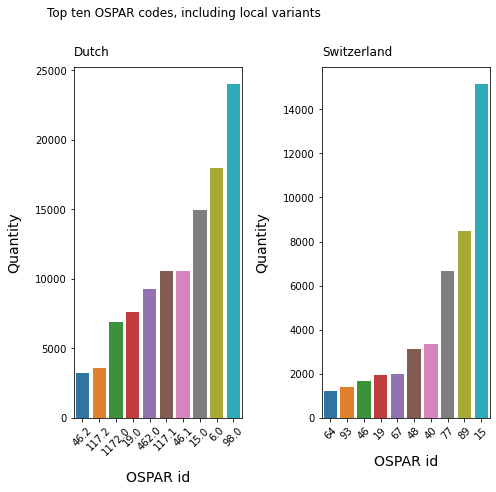

In [29]:
# set some params
title_k = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12}
xlab_k = {'labelpad':12, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}

# plot that

fig, axs = plt.subplots(1,2, figsize=(7,7))

sns.barplot(data=topten_d.iloc[:10], x=topten_d.iloc[:10].index, y=topten_d.iloc[:10], ax=axs[0])
sns.barplot(data=topten_ch.iloc[:10], x=topten_ch.iloc[:10].index, y=topten_ch.iloc[:10], ax=axs[1])
xticklabels =topten_d.iloc[:10].index.values
axs[0].set_title('Dutch', **title_k)
axs[0].set_xticklabels(xticklabels, rotation = 45, ha="center")
axs[0].set_xlabel('OSPAR id', **xlab_k14)
axs[0].set_ylabel('Quantity', **xlab_k14)

xticklabels =topten_ch.iloc[:10].index.values
axs[1].set_title('Switzerland', **title_k)
axs[1].set_xticklabels(xticklabels, rotation = 45, ha="center")
axs[1].set_xlabel('OSPAR id', **xlab_k14)
axs[1].set_ylabel('Quantity', **xlab_k14)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=None)
plt.suptitle("Top ten OSPAR codes, including local variants", y=.97, ha='left',x=.1)
fname = F"{project_directory}/initial_topten_results.jpg"
plt.savefig(fname, dpi=300,)

plt.show()


In [30]:
# make a top ten without local variants
ospar_to_ospar = dutch_codes[[ 'ospar_id', 'parent_code']].drop_duplicates()
ospar_to_ospar.set_index('ospar_id', drop=True, inplace=True)
ospar_to_ospar.loc[21]

parent_code    21
Name: 21.0, dtype: int64

In [31]:
def anosparmap(x, defs):
    try:
        val = defs.loc[x][0]
    except:
        val = 0
        print(x)
    return val

use_these['new_id'] = use_these.ospar_id.map(lambda x:  anosparmap(x, ospar_to_ospar))

In [32]:
# group and sort by code values:
code_totals_dutch = use_these.groupby('new_id').quantity.sum()
code_totals_swiss = ch_dated.groupby('ospar_id').quantity.sum()
topten_d = code_totals_dutch.sort_values(ascending=False)
topten_ch = code_totals_swiss.sort_values(ascending=False)

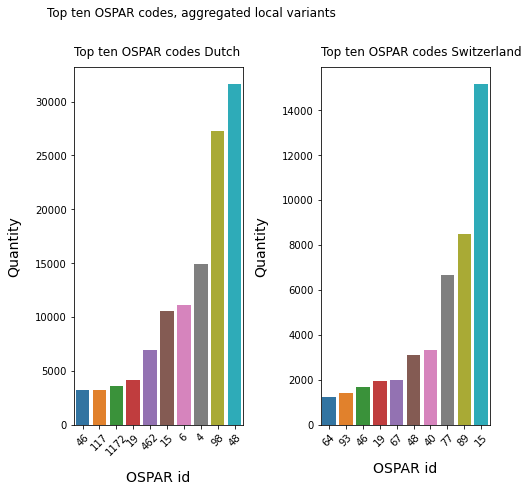

In [33]:
# set some params
title_k = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12}
xlab_k = {'labelpad':12, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}

# plot that

fig, axs = plt.subplots(1,2, figsize=(7,7))

sns.barplot(data=topten_d.iloc[:10], x=topten_d.iloc[:10].index, y=topten_d.iloc[:10], ax=axs[0])
sns.barplot(data=topten_ch.iloc[:10], x=topten_ch.iloc[:10].index, y=topten_ch.iloc[:10], ax=axs[1])
xticklabels =topten_d.iloc[:10].index.values
axs[0].set_title('Top ten OSPAR codes Dutch', **title_k)
axs[0].set_xticklabels(xticklabels, rotation = 45, ha="center")
axs[0].set_xlabel('OSPAR id', **xlab_k14)
axs[0].set_ylabel('Quantity', **xlab_k14)

xticklabels =topten_ch.iloc[:10].index.values
axs[1].set_title('Top ten OSPAR codes Switzerland', **title_k)
axs[1].set_xticklabels(xticklabels, rotation = 45, ha="center")
axs[1].set_xlabel('OSPAR id', **xlab_k14)
axs[1].set_ylabel('Quantity', **xlab_k14)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=None)
plt.suptitle("Top ten OSPAR codes, aggregated local variants", y=.97, ha='left',x=.1)
fname = F"{project_directory}/initial_topten_results_agg.jpg"
plt.savefig(fname, dpi=300,)

plt.show()


In [34]:
dutch_codes.columns

Index(['ID', 'description', 'category', 'ospar_id', 'parent_code',
       'child_code'],
      dtype='object')

In [35]:
# these are the Swiss codes with appropriate correct ospar id
codes
scodes_project = swiss_codes[swiss_codes.index.isin(scodes_used.index)]
scodes_project.to_csv(F"{codes}/swiss_codes_keyed_ospar.csv")

### Choose the correct definition for MLW codes that have many OSPAR ids.

The EU is putting together a list of harmonized codes that makes it easier to switch between different systems. We will try and consult that list before making any hasty decisions.

### Account for equivalencies for dutch child codes

Both projects use a coding system for items of local concern (sub codes or child codes) we need to find each projects analog and use appropriate OSPAR code.



In [36]:
## !!! refresh the data from the hammerdirt api here:

# a = requests.get('https://mwshovel.pythonanywhere.com/api/surveys/daily-totals/code-totals/swiss/')
# b = requests.get('https://mwshovel.pythonanywhere.com/api/list-of-beaches/swiss/')
# c = requests.get('https://mwshovel.pythonanywhere.com/api/mlw-codes/list/')

# # the surveys need to be unpacked:
# swiss_surveys = ut.unpack_survey_results(a.json())
# swiss_surveys = pd.DataFrame(swiss_surveys)

# # adding location date column
# swiss_surveys['loc_date'] = list(zip(swiss_surveys['location'], swiss_surveys['date']))

# # hold the original
# x = a.json()

# print("survey columns")
# print(swiss_surveys.columns)

# swiss_beaches = pd.DataFrame(b.json())
# print("beach columns")
# print(swiss_beaches.columns)

# print("code columns")
# swiss_codes = pd.DataFrame(c.json())
# print(swiss_codes.columns)

# swiss_surveys.to_csv(data+'/hammerdirt_data.csv')
# swiss_beaches.to_csv(beaches+'/hammerdirt_beaches.csv')
# swiss_codes.to_csv(codes+'/swiss_codes.csv')
